In [2]:
import numpy as np #mathematical and scientific operations
import pandas as pd #manipulate datasets
import matplotlib.pyplot as plt#Used to create visualizations and plots.
from sklearn.model_selection import train_test_split#split data into training and testing sets
from sklearn.linear_model import LinearRegression#To use Linear Regression,
from sklearn.ensemble import RandomForestRegressor#a more advanced algorithm.
from sklearn.preprocessing import StandardScaler#To scale/standardize data before applying Linear Regression.
#Features like “distance” (e.g., 0–50 km) and “hour” (0–23) have different scales.
#Scaling brings all values to a similar range, improving model accuracy.
from sklearn.metrics import r2_score, mean_squared_error #evaluate model performance.


In [3]:
df = pd.read_csv("uber.csv")
df.columns = df.columns.str.lower().str.strip() #column names are converted to lowercase
df.head()

,unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.shape

(200000, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [6]:
df.isnull().sum()

unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
# preprocessing 
df = df.dropna()
df.isnull().sum()

unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
#Convert Date & Time to extract hour, day, and month as separate new columns on which Fare prices can depend
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df.head()

,unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8


In [21]:
#shortest distance between two GPS coordinates (in kilometers).
#Fare amount strongly depends on distance traveled.
#But we only had coordinates (latitudes/longitudes), We now have a new column distance_km that tells us how long each trip was.
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                              df['dropoff_latitude'], df['dropoff_longitude'])



In [23]:
df.head()

,unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,distance_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,4.475450


In [27]:
#Filter Unrealistic or Wrong Data
#Fare should be positive (>0)
#Distance should be greater than 0
#Distance should not exceed 100 km (Uber rides are rarely that long)
df = df[(df['fare_amount'] > 0) & (df['distance_km'] > 0) & (df['distance_km'] < 100)]


In [29]:
#Passenger Count Check-Uber cars can’t have 0 passengers or more than 8 passengers.
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 8)]
df.head()

,unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,distance_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,4.475450


Text(0, 0.5, 'fare_amount')

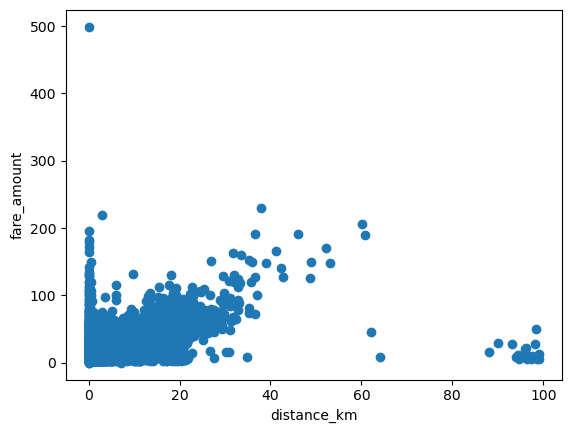

In [31]:
#outliers-A normal Uber fare might be between ₹50 and ₹1000.
#If you see one fare as ₹25,000 — that’s clearly an outlier. 500km is also an outliers 
plt.scatter(df['distance_km'], df['fare_amount'])
plt.xlabel("distance_km")
plt.ylabel("fare_amount")

In [32]:
def iqr_bounds(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = max(0, q1 - 1.5 * iqr)   # lower bound cannot be less than 0
    upper = q3 + 1.5 * iqr
    return lower, upper

fare_low, fare_high = iqr_bounds(df['fare_amount'])
dist_low, dist_high = iqr_bounds(df['distance_km'])

print(f"Fare bounds: {fare_low:.2f} to {fare_high:.2f}")
print(f"Distance bounds: {dist_low:.2f} to {dist_high:.2f}")

Fare bounds: 0.00 to 22.25
Distance bounds: 0.00 to 7.93


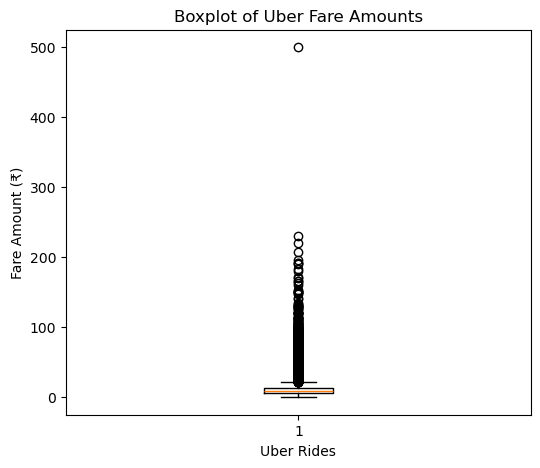

In [35]:

plt.figure(figsize=(6, 5))
plt.boxplot(df['fare_amount'])
plt.title("Boxplot of Uber Fare Amounts")
plt.ylabel("Fare Amount (₹)")
plt.xlabel("Uber Rides")
plt.show()

#The small box at the bottom = most of your fare or distance values are very small

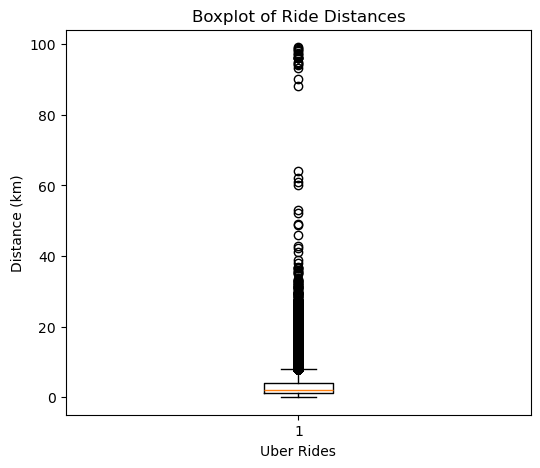

In [37]:
plt.figure(figsize=(6, 5))
plt.boxplot(df['distance_km'])
plt.title("Boxplot of Ride Distances")
plt.ylabel("Distance (km)")
plt.xlabel("Uber Rides")
plt.show()
#squeezed box- most rides are short

In [39]:
#correaltion analysis 
#how strongly two variables are related to each other. +1 perfect tgther increase 0 - no relation -1 one increease other decrease

In [41]:
corr = df[['fare_amount', 'distance_km', 'passenger_count', 'hour', 'day', 'month']].corr()
print(corr)
#farevs distance close to 1 = when dis increase fare shld too

                 fare_amount  distance_km  passenger_count      hour  \
fare_amount         1.000000     0.840989         0.011897 -0.020736   
distance_km         0.840989     1.000000         0.007359 -0.030529   
passenger_count     0.011897     0.007359         1.000000  0.014761   
hour               -0.020736    -0.030529         0.014761  1.000000   
day                 0.000188     0.000818         0.002602  0.005546   
month               0.024174     0.011896         0.008776 -0.004274   

                      day     month  
fare_amount      0.000188  0.024174  
distance_km      0.000818  0.011896  
passenger_count  0.002602  0.008776  
hour             0.005546 -0.004274  
day              1.000000 -0.017264  
month           -0.017264  1.000000  


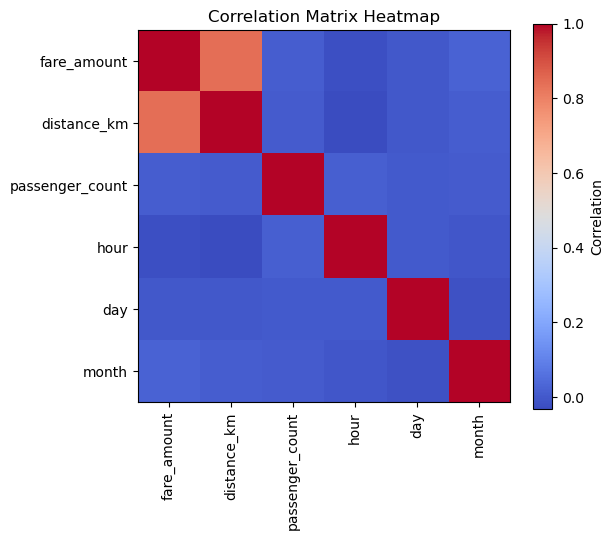

In [43]:
# visualize corealtion with heatmap
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix Heatmap")
plt.show()
#Red or dark colors → strong positive correlation
#Blue → negative correlation
#Light colors → weak or no correlation

In [51]:
#Model Building and Evaluation
X = df[['distance_km', 'passenger_count', 'hour', 'day', 'month']]
y = df['fare_amount']
#X = all the input features used to predict fare.
#y = target/output column (the actual fare amount).

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#scale as distance, hour all might be in diff scales

In [57]:
#train model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [59]:
#random forest model
#Random Forest builds many decision trees (100 in this case).
#Each tree predicts a fare, and the final output is the average of all trees.
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [67]:
# Evaluate Models
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> R²: {r2:.3f}, RMSE: {rmse:.3f}")
    return r2, rmse

r2_lr, rmse_lr = evaluate_model("Linear Regression", y_test, y_pred_lr)
r2_rf, rmse_rf = evaluate_model("Random Forest", y_test, y_pred_rf)

print("\nLinear Regression Results:")
print(f"R² Score: {r2_lr:.3f}")
print(f"RMSE: {rmse_lr:.3f}")

print("\nRandom Forest Results:")
print(f"R² Score: {r2_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
#r2-How much variation in fare is explained by the model 
#RMSE (Root Mean Squared Error)-Average prediction error-Random Forest makes smaller mistakes, so it’s more precise.
#The R² score shows how well the model fits the data. Random Forest gave a higher R² (0.72), so it explains the fare variations better than Linear Regression (0.66).”

Linear Regression -> R²: 0.666, RMSE: 5.725
Random Forest -> R²: 0.721, RMSE: 5.227

Linear Regression Results:
R² Score: 0.666
RMSE: 5.725

Random Forest Results:
R² Score: 0.721
RMSE: 5.227


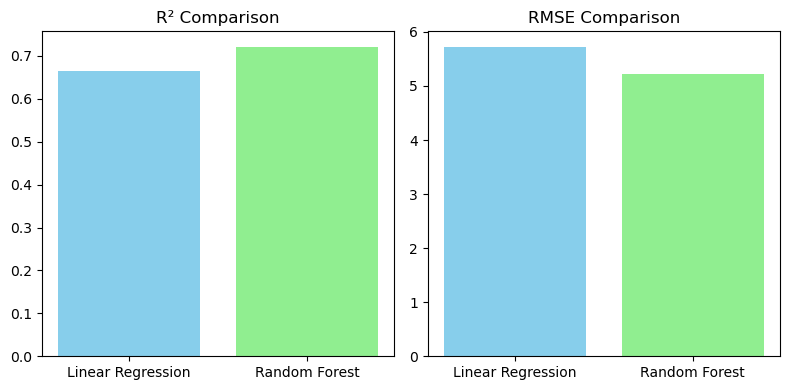

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

models = ['Linear Regression', 'Random Forest']
r2_scores = [r2_lr, r2_rf]
rmse_scores = [rmse_lr, rmse_rf]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.bar(models, r2_scores, color=['skyblue', 'lightgreen'])
plt.title("R² Comparison")

plt.subplot(1,2,2)
plt.bar(models, rmse_scores, color=['skyblue', 'lightgreen'])
plt.title("RMSE Comparison")

plt.tight_layout()
plt.show()